In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import numpy as np
import copy
import json
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

import IPython
from IPython.display import Image as img
from IPython.display import display

from PIL import Image

import torch
import torch.nn as nn
import torchvision

In [4]:
from src.datamodules.datasets.emoreccom import EmoRecComDataset

In [17]:
emoreccom_path = "/userfiles/comics_grp/multimodal_emotion_recognition_on_comics_scenes/"
dataset = EmoRecComDataset(emoreccom_path, train=False)

angry 		 --> 0.0 | 0.0
disgust 	 --> 0.0 | 0.0
fear 		 --> 0.0 | 0.0
happy 		 --> 0.0 | 0.0
sad 		 --> 0.0 | 0.0
surprise 	 --> 0.0 | 0.0
neutral 	 --> 0.0 | 0.0
other 		 --> 0.0 | 0.0

### Dialogs:
-->  all right , i weel explain . one by outlaws . they come to my cafe thinking it ees safe . then aa leetle too much wine .... poof into thee underground river that flows here ! abut you 
--> but you have no right to do this

### Narratives:




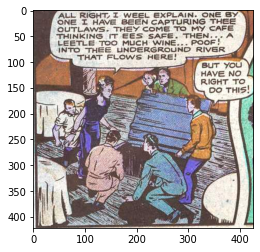

In [18]:
img, sizes, (labels, polarities), (narrative, dialog) = dataset.__getitem__(np.random.randint(dataset.__len__()))

for emotion, value, polarity in zip(dataset.emotion_list, labels, polarities):
    print(emotion, "\t\t" if len(emotion) <= 5 else "\t", "-->", value, "|", polarity)

print("\n### Dialogs:")
for d in dialog:
    print("-->", d)

print("\n### Narratives:")
for n in narrative:
    print("-->", n)

print("\n")

plt.imshow(img)